In [4]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [27]:
Player_Price = pd.read_csv("/Users/munirahalzuman/Downloads/final_data.csv")



In [5]:
Player_Price.head()

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.000000,0.000000,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.000000,0.000000,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
2,/tom-heaton/profil/spieler/34130,Manchester United,Tom Heaton,Goalkeeper,188.0,37.0,4,0.000000,0.000000,0.000000,...,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
3,/lisandro-martinez/profil/spieler/480762,Manchester United,Lisandro Martínez,Defender Centre-Back,175.0,25.0,82,0.028090,0.056180,0.224719,...,0.000000,0.000000,6408,175,22,9,50000000,50000000,2,0
4,/raphael-varane/profil/spieler/164770,Manchester United,Raphaël Varane,Defender Centre-Back,191.0,30.0,63,0.017889,0.017889,0.053667,...,0.000000,0.000000,5031,238,51,21,40000000,80000000,2,0


In [6]:
Player_Price.shape

(10754, 22)

In [4]:
Player_Price.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [14]:
# uniqeness
Player_Price.duplicated().sum()

0

In [15]:
# Completeness
Player_Price.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [16]:
# Accurecy types
Player_Price.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [17]:
# Accurecy - Outlier

In [28]:
#investigate all the elemenys within each feature

for column in Player_Price:
    unique_vals = np.unique(Player_Price[column].fillna('0'))
    nr_values = len(unique_vals)
    if nr_values <= 16:
        print(f'The number of values for feature {column} :{nr_values}--{unique_vals}')
    else:
        print(f'The number of values for feature {column} :{nr_values}')

The number of values for feature player :10754
The number of values for feature team :374
The number of values for feature name :10584
The number of values for feature position :16--['Attack' 'Attack Centre-Forward' 'Attack-LeftWinger' 'Attack-RightWinger'
 'Attack-SecondStriker' 'Defender' 'Defender Centre-Back'
 'Defender Left-Back' 'Defender Right-Back' 'Goalkeeper' 'midfield'
 'midfield-AttackingMidfield' 'midfield-CentralMidfield'
 'midfield-DefensiveMidfield' 'midfield-LeftMidfield'
 'midfield-RightMidfield']
The number of values for feature height :47
The number of values for feature age :30
The number of values for feature appearance :108
The number of values for feature goals :5329
The number of values for feature assists :5065
The number of values for feature yellow cards :6291
The number of values for feature second yellow cards :1095
The number of values for feature red cards :1219
The number of values for feature goals conceded :742
The number of values for feature clean s

In [29]:
#Position column contains a mix of generic and specific roles, 
#we need to preprocess the data to handle this effectively and avoid redundancy or noise in the model.

position_mapping = {
    'Attack': 'Attack',
    'Attack Centre-Forward': 'Attack',
    'Attack-LeftWinger': 'Attack',
    'Attack-RightWinger': 'Attack',
    'Attack-SecondStriker': 'Attack',
    'Defender': 'Defender',
    'Defender Centre-Back': 'Defender',
    'Defender Left-Back': 'Defender',
    'Defender Right-Back': 'Defender',
    'Goalkeeper': 'Goalkeeper',
    'midfield': 'Midfield',
    'midfield-AttackingMidfield': 'Midfield',
    'midfield-CentralMidfield': 'Midfield',
    'midfield-DefensiveMidfield': 'Midfield',
    'midfield-LeftMidfield': 'Midfield',
    'midfield-RightMidfield': 'Midfield'
}

# Apply the mapping
Player_Price['Position_Group'] = Player_Price['position'].map(position_mapping)

In [30]:
# Get unique combinations of 'Position_Group' and 'position_encoded'
unique_positions = Player_Price[['Position_Group', 'position_encoded']].drop_duplicates()

# Display the result
unique_positions

,Position_Group,position_encoded
0,Goalkeeper,1
3,Defender,2
14,Midfield,3
23,Attack,4


In [31]:
# Check if all the values in the 'height' column of the Player_Price DataFrame are integers.
print(Player_Price['height'].apply(float.is_integer).all())
# Check if all the values in the 'age' column of the Player_Price DataFrame are integers.
print(Player_Price['age'].apply(float.is_integer).all())

False
False


In [32]:
# Check if all values in the columns are integers (though stored as floats)
columns_to_check = ['goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets']
for col in columns_to_check:
    print(f"Column '{col}' contains only integers: {Player_Price[col].apply(float.is_integer).all()}")

Column 'goals' contains only integers: False
Column 'assists' contains only integers: False
Column 'yellow cards' contains only integers: False
Column 'second yellow cards' contains only integers: False
Column 'red cards' contains only integers: False
Column 'goals conceded' contains only integers: False
Column 'clean sheets' contains only integers: False


In [33]:
# For each column in the list 'columns_to_check', round the values to 0 decimal places, 
# then convert the values to integers (int64 type) and update the column in the Player_Price DataFrame.
for col in columns_to_check:
    Player_Price[col] = Player_Price[col].round(0).astype('int64')

In [9]:
Player_Price.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                    int64
assists                  int64
yellow cards             int64
second yellow cards      int64
red cards                int64
goals conceded           int64
clean sheets             int64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
Position_Group          object
dtype: object

<Figure size 1500x800 with 0 Axes>

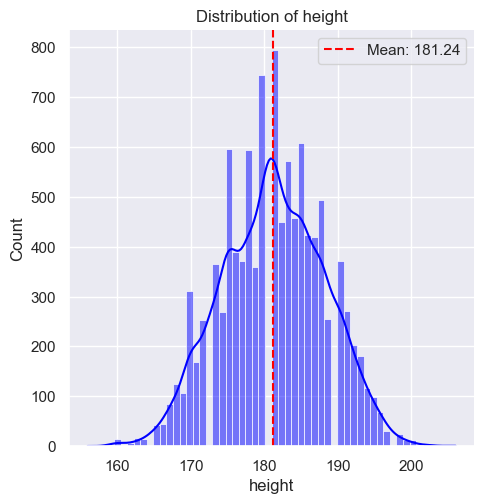

In [34]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['height'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of height')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['height'].mean()
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

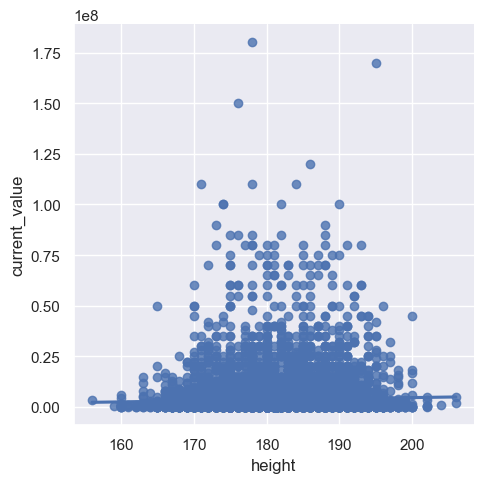

In [37]:
sns.lmplot(x='height',y='current_value', data=Player_Price, fit_reg=True, ci=None)

<Figure size 1500x800 with 0 Axes>

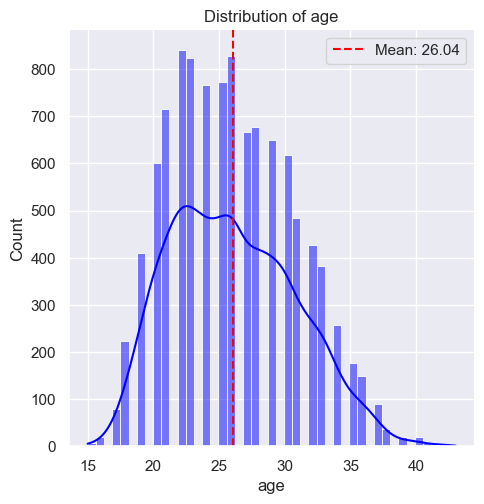

In [47]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['age'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of age')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['age'].mean()
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

In [52]:
Player_Price[Player_Price['age'] == 15]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger,Position_Group
6724,/stiven-jimenez/profil/spieler/1008431,FC Cincinnati,Stiven Jimenez,midfield-DefensiveMidfield,168.000000,15.0,9,0,0,1,...,0,660,0,0,0,0,0,3,0,Midfield
6989,/nimfasha-berchimas/profil/spieler/1000273,Charlotte FC,Nimfasha Berchimas,Attack-LeftWinger,181.240353,15.0,1,0,0,0,...,0,65,0,0,0,25000,25000,4,1,Attack
7267,/luis-rivera/profil/spieler/999379,Real Salt Lake City,Luis Rivera,Defender Centre-Back,181.240353,15.0,7,0,0,0,...,0,472,0,0,0,50000,50000,2,0,Defender
7290,/axel-kei/profil/spieler/921859,Real Salt Lake City,Axel Kei,Attack Centre-Forward,185.000000,15.0,1,0,0,0,...,0,44,103,18,0,0,0,4,0,Attack
7427,/maximo-carrizo/profil/spieler/989968,New York City FC,Máximo Carrizo,midfield-AttackingMidfield,160.000000,15.0,4,0,0,0,...,0,295,0,0,0,0,0,3,0,Midfield
8662,/taiga-kameda/profil/spieler/1126311,Vissel Kobe,Taiga Kameda,Goalkeeper,183.000000,15.0,5,0,0,0,...,0,450,0,0,0,0,0,1,0,Goalkeeper


<Figure size 1500x800 with 0 Axes>

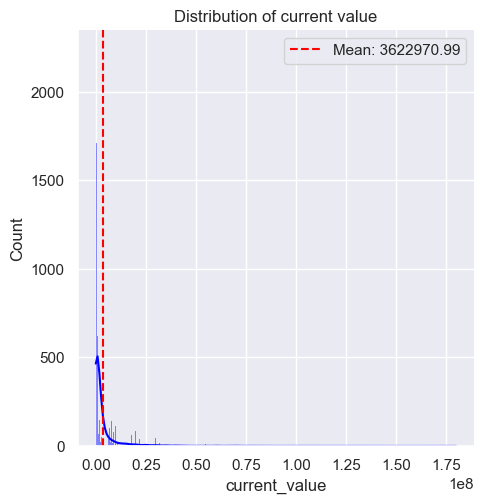

In [53]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['current_value'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of current value')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['current_value'].mean()
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

In [34]:
# Identify rows where 'current_value' is greater than 100,000,000 
condition = Player_Price['current_value'] > 100000000 

# Drop these rows from the DataFrame
Player_Price = Player_Price[~condition]

<Figure size 1500x800 with 0 Axes>

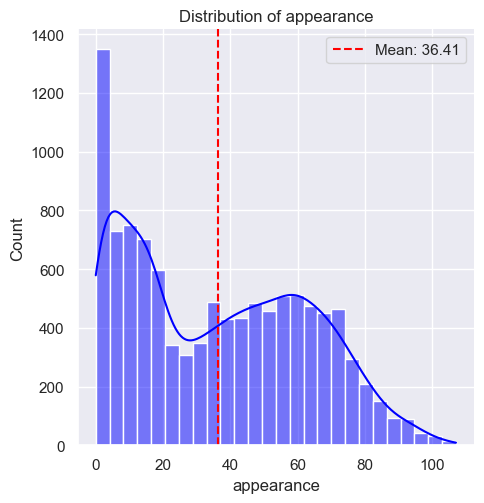

In [70]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['appearance'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of appearance')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['appearance'].mean()
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

In [136]:
Player_Price[Player_Price['appearance'] == 0]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger,Position_Group
189,/andy-lonergan/profil/spieler/14044,Everton FC,Andy Lonergan,Goalkeeper,193.000000,39.0,0,0,0,0,...,0,0,255,32,3,200000,700000,1,0,Goalkeeper
322,/darren-randolph/profil/spieler/51321,AFC Bournemouth,Darren Randolph,Goalkeeper,187.000000,36.0,0,0,0,0,...,0,0,103,18,1,500000,4500000,1,0,Goalkeeper
349,/matthew-cox/profil/spieler/741236,Brentford FC,Matthew Cox,Goalkeeper,183.000000,20.0,0,0,0,0,...,0,0,0,0,0,500000,500000,1,0,Goalkeeper
565,/niklas-klinger/profil/spieler/192268,VfL Wolfsburg,Niklas Klinger,Goalkeeper,187.000000,27.0,0,0,0,0,...,0,0,132,24,3,100000,100000,1,0,Goalkeeper
620,/jakob-busk/profil/spieler/203411,1.FC Union Berlin,Jakob Busk,Goalkeeper,189.000000,29.0,0,0,0,0,...,0,0,134,22,2,250000,800000,1,0,Goalkeeper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10650,/james-nieuwenhuizen/profil/spieler/1064381,Melbourne City FC,James Nieuwenhuizen,Goalkeeper,181.240353,19.0,0,0,0,0,...,0,0,0,0,0,25000,25000,1,0,Goalkeeper
10660,/emile-peios/profil/spieler/1118353,Melbourne City FC,Emile Peios,midfield,181.240353,19.0,0,0,0,0,...,0,0,0,0,0,25000,25000,3,0,Midfield
10663,/emin-durakovic/profil/spieler/1066862,Melbourne City FC,Emin Durakovic,midfield-LeftMidfield,181.240353,17.0,0,0,0,0,...,0,0,0,0,0,25000,25000,3,1,Midfield
10673,/arion-sulemani/profil/spieler/1066861,Melbourne City FC,Arion Sulemani,Attack Centre-Forward,181.240353,18.0,0,0,0,0,...,0,0,101,12,0,25000,25000,4,0,Attack


In [138]:
Player_Price['appearance'].value_counts()

appearance
1      294
17     220
4      220
10     214
5      207
      ... 
98       3
106      2
104      2
107      2
103      1
Name: count, Length: 107, dtype: int64

<Figure size 1500x800 with 0 Axes>

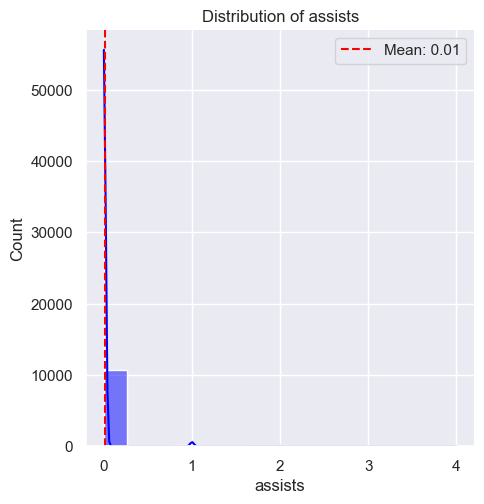

In [76]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['assists'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of assists')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['assists'].mean()
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

<Figure size 1500x800 with 0 Axes>

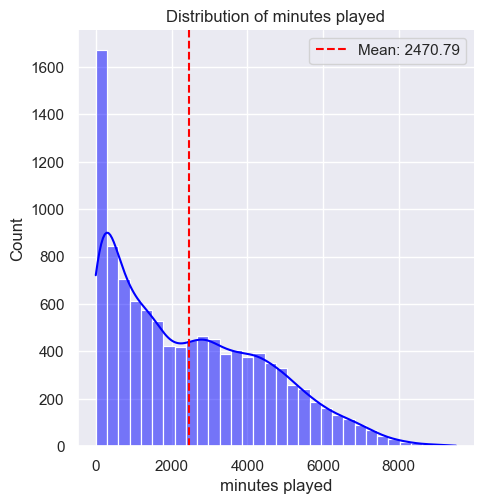

In [78]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['minutes played'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of minutes played')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['minutes played'].mean()

plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

In [ ]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['goals'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of goals')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['goals'].mean()

plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

In [84]:
Player_Price[(Player_Price['appearance'] == 0) |(Player_Price['minutes played'] == 0)]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger,Position_Group
189,/andy-lonergan/profil/spieler/14044,Everton FC,Andy Lonergan,Goalkeeper,193.000000,39.0,0,0,0,0,...,0,0,255,32,3,200000,700000,1,0,Goalkeeper
322,/darren-randolph/profil/spieler/51321,AFC Bournemouth,Darren Randolph,Goalkeeper,187.000000,36.0,0,0,0,0,...,0,0,103,18,1,500000,4500000,1,0,Goalkeeper
349,/matthew-cox/profil/spieler/741236,Brentford FC,Matthew Cox,Goalkeeper,183.000000,20.0,0,0,0,0,...,0,0,0,0,0,500000,500000,1,0,Goalkeeper
565,/niklas-klinger/profil/spieler/192268,VfL Wolfsburg,Niklas Klinger,Goalkeeper,187.000000,27.0,0,0,0,0,...,0,0,132,24,3,100000,100000,1,0,Goalkeeper
620,/jakob-busk/profil/spieler/203411,1.FC Union Berlin,Jakob Busk,Goalkeeper,189.000000,29.0,0,0,0,0,...,0,0,134,22,2,250000,800000,1,0,Goalkeeper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10660,/emile-peios/profil/spieler/1118353,Melbourne City FC,Emile Peios,midfield,181.240353,19.0,0,0,0,0,...,0,0,0,0,0,25000,25000,3,0,Midfield
10663,/emin-durakovic/profil/spieler/1066862,Melbourne City FC,Emin Durakovic,midfield-LeftMidfield,181.240353,17.0,0,0,0,0,...,0,0,0,0,0,25000,25000,3,1,Midfield
10673,/arion-sulemani/profil/spieler/1066861,Melbourne City FC,Arion Sulemani,Attack Centre-Forward,181.240353,18.0,0,0,0,0,...,0,0,101,12,0,25000,25000,4,0,Attack
10699,/ethan-cox/profil/spieler/745416,Adelaide United,Ethan Cox,Goalkeeper,181.240353,19.0,0,0,0,0,...,0,0,0,0,0,50000,50000,1,0,Goalkeeper


In [11]:
Player_Price[Player_Price['minutes played'] == 0]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger,Position_Group


<Figure size 1500x800 with 0 Axes>

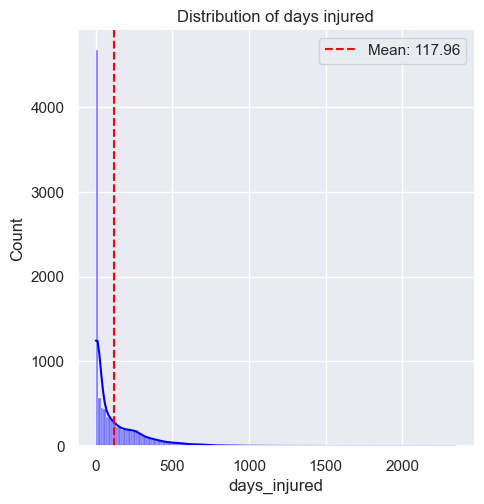

In [90]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['days_injured'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of days injured')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['days_injured'].mean()
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

<Figure size 1500x800 with 0 Axes>

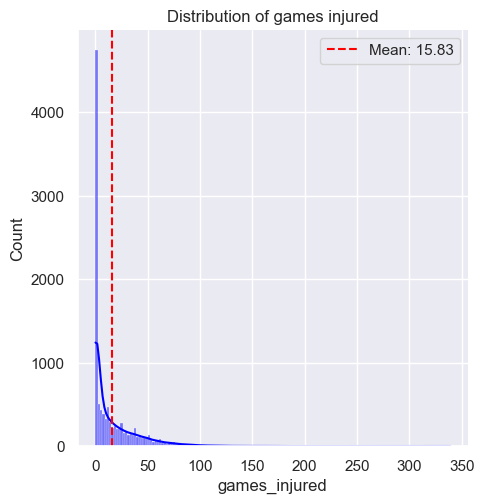

In [92]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['games_injured'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of games injured')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['games_injured'].mean()
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

<Figure size 1500x800 with 0 Axes>

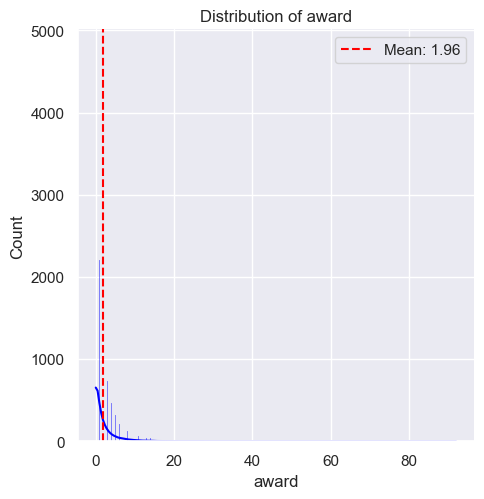

In [93]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['award'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of award')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['award'].mean()
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

<Figure size 1500x800 with 0 Axes>

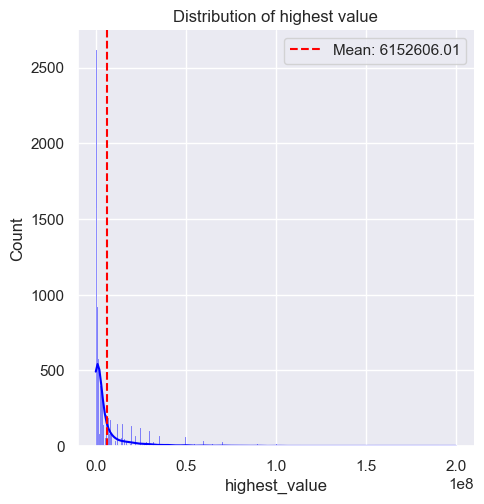

In [94]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['highest_value'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of highest value')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['highest_value'].mean()
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

<Figure size 1500x800 with 0 Axes>

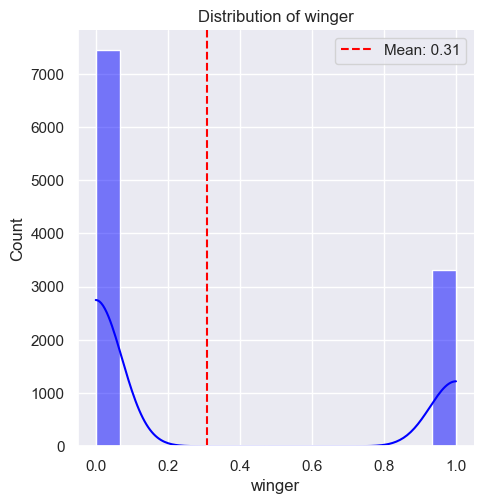

In [95]:
plt.figure(figsize=(15,8))


# Creating a distribution plot for each numeric column
sns.displot(Player_Price['winger'], kde=True, color='blue')  # Add kde=True for the density curve
plt.title(f'Distribution of winger')  # Add a title for better readability
    
# Calculating and plotting the mean
mean = Player_Price['winger'].mean()
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Display mean with a label
plt.legend()  # Show legend for mean line
plt.show()  # Display the plot

In [14]:
from scipy.stats import zscore  # Import zscore from scipy.stats

# Calculate the z-scores for the 'winger' column and get the unique values
z_scores = zscore(Player_Price['winger'])
unique_z_scores = pd.Series(z_scores).unique()
unique_z_scores

array([-0.67862089,  1.4735768 ])

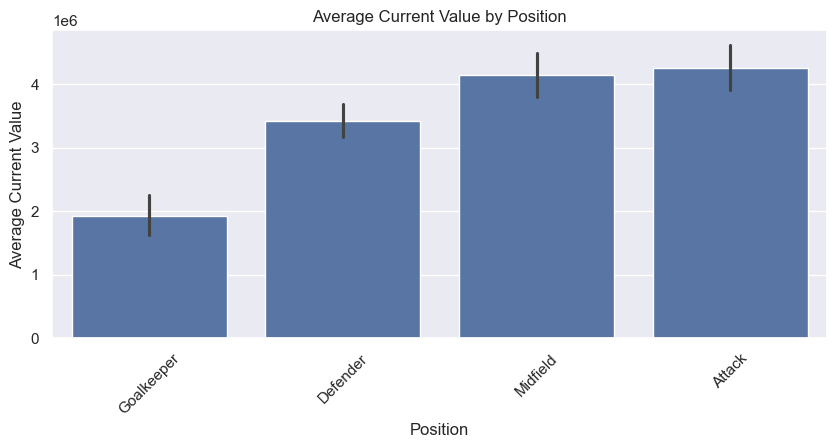

In [168]:
plt.figure(figsize=(10,4))
# Barplot to show the mean current_value for each position
sns.barplot(data=Player_Price, x='Position_Group', y='current_value') 
plt.title('Average Current Value by Position')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xlabel('Position')
plt.ylabel('Average Current Value')
plt.show()

In [147]:
Player_Price['team'].value_counts()

team
Jeonbuk Hyundai Motors    45
Daejeon Hana Citizen      44
Gangwon FC                42
Daegu FC                  42
Royal AM FC               39
                          ..
CA Osasuna                22
Manchester City           21
Newcastle United Jets     21
Club Atlético Tucumán     21
Hatayspor                 12
Name: count, Length: 373, dtype: int64

In [35]:
# Calculate the 35th and 75th percentiles of the price
p35 = Player_Price['current_value'].quantile(0.35)
p75 = Player_Price['current_value'].quantile(0.75)



In [36]:
# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Low'
    elif price < p75:
        return 'Medium'
    else:
        return 'High'

# Apply the function to create a new column
Player_Price['current_value_category'] = Player_Price['current_value'].apply(categorize_price)

Player_Price.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(Player_Price['current_value_category'].value_counts())

current_value_category
Medium    4267
Low       3754
High      2726
Name: count, dtype: int64


In [37]:
p35, p75

(450000.0, 2800000.0)

In [38]:
encoder = LabelEncoder()
Player_Price['current_value_category'] = encoder.fit_transform(Player_Price['current_value_category'])  

#### 3. Feature selection

In [39]:
Player_Price_new = Player_Price.drop(['player', 'team', 'name', 'position', 'position_encoded'], axis =1)

In [40]:
Player_Price_new = pd.get_dummies(Player_Price_new, columns =['Position_Group'])

In [41]:
Player_Price_new.columns

Index(['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
       'second yellow cards', 'red cards', 'goals conceded', 'clean sheets',
       'minutes played', 'days_injured', 'games_injured', 'award',
       'highest_value', 'winger', 'current_value_category',
       'Position_Group_Attack', 'Position_Group_Defender',
       'Position_Group_Goalkeeper', 'Position_Group_Midfield'],
      dtype='object')

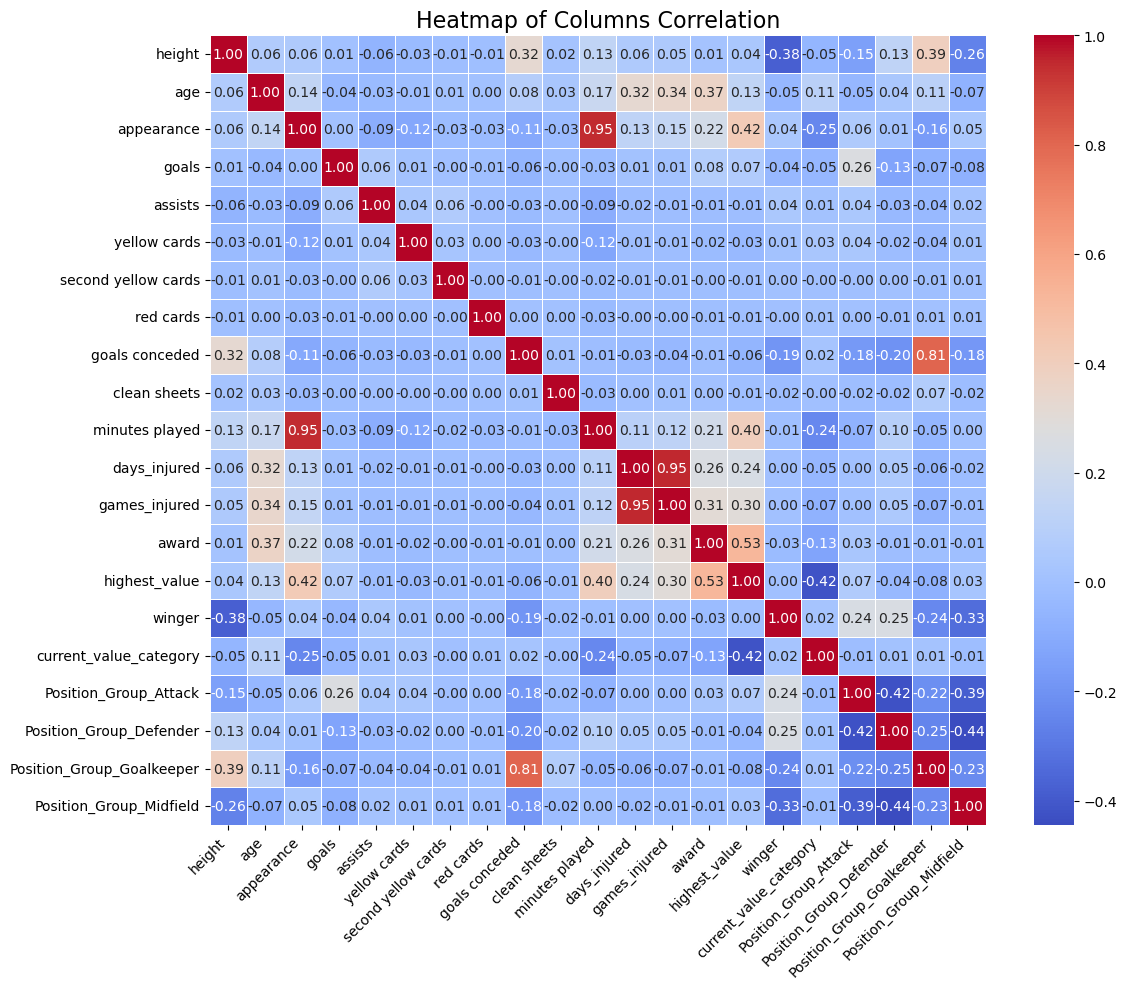

In [42]:
# Calculate the correlation matrix
correlation_matrix = Player_Price_new.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Customize the plot
plt.title("Heatmap of Columns Correlation", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [43]:
correlation = Player_Price_new.corr()
print(correlation['current_value_category'].sort_values(ascending=False))

current_value_category       1.000000
age                          0.106951
yellow cards                 0.032262
winger                       0.022925
goals conceded               0.022738
Position_Group_Goalkeeper    0.014650
Position_Group_Defender      0.011014
red cards                    0.008493
assists                      0.007136
clean sheets                -0.002756
second yellow cards         -0.003897
Position_Group_Attack       -0.010407
Position_Group_Midfield     -0.011522
days_injured                -0.047473
goals                       -0.048455
height                      -0.053938
games_injured               -0.067565
award                       -0.132059
minutes played              -0.240232
appearance                  -0.245744
highest_value               -0.417142
Name: current_value_category, dtype: float64


In [44]:
# Set the correlation threshold
threshold = 0.1  

# Filter the correlations
selected_features = correlation[abs(correlation['current_value_category']) > threshold]['current_value_category'].index
selected_features

Index(['age', 'appearance', 'minutes played', 'award', 'highest_value',
       'current_value_category'],
      dtype='object')

In [45]:
selected_features = ['age', 'appearance', 'minutes played', 'award', 'highest_value',
       'current_value_category']

In [46]:
new_Player_raw = Player_Price_new[selected_features]
new_Player_raw.head()

,age,appearance,minutes played,award,highest_value,current_value_category
0,32.0,104,9390,13,70000000,0
1,30.0,15,1304,1,22000000,2
2,37.0,4,292,4,6000000,2
3,25.0,82,6408,9,50000000,0
4,30.0,63,5031,21,80000000,0


# Prepare train and test data

In [47]:
# Prepare data
x = new_Player_raw.drop(['current_value_category'], axis = 1)
x_coulmns = new_Player_raw.drop(['current_value_category'], axis = 1)
y = new_Player_raw['current_value_category']




In [48]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
x.shape

(10747, 5)

## Buliding the Model

In [50]:
svm_classifier = SVC() 

In [51]:
param_grid = {
    'kernel': [
             # 'linear',
               'rbf',
             # 'poly'
              ],   # Regularization strength
    'C':[0, 2, 5, 10, 15, 20, 25],
    'gamma': [1,2,6]
}
grid_search = GridSearchCV(estimator=svm_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [52]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0, 2, 5, 10, 15, 20, 25], 'gamma': [1, 2, 6],
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [53]:
grid_search.best_params_

{'C': 25, 'gamma': 1, 'kernel': 'rbf'}

In [54]:
model = grid_search.best_estimator_

## Test the Model

In [55]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [56]:
# our benchmark model
base_model = round(new_Player_raw['current_value_category'].value_counts()[1]/new_Player_raw.shape[0]*100, 2)
base_model


34.93

1. Accuracy

In [57]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8372093023255814

In [58]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.8971734325927649

In [59]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[457,   1,  70],
       [  6, 643, 106],
       [ 64, 103, 700]])

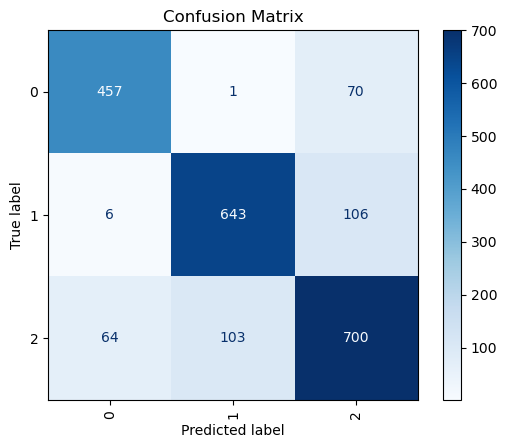

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [61]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.84


In [62]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.84


In [63]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.84


In [64]:
print(classification_report(y_test,
                      y_pred,
                      labels=list(model.classes_)))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       528
           1       0.86      0.85      0.86       755
           2       0.80      0.81      0.80       867

    accuracy                           0.84      2150
   macro avg       0.84      0.84      0.84      2150
weighted avg       0.84      0.84      0.84      2150

